In [1]:
from IPython.display import SVG
from matplotlib      import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from collections     import Counter

import numpy as np
import mido
import librosa as lbr
from   librosa.display     import specshow

from keras.models          import load_model
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# 1. Load the Song.

In [2]:
songName = './Test songs/Big Bill Broonzy & Chas Segar - Key to the Highway (Cover by Rog Bates).mp3'
nBins, nFrames = 4, 7

song = lbr.effects.trim(lbr.load(songName)[0])[0]
songLen = int(lbr.get_duration(song))
print('Song duration\t{} min : {} sec'.format(songLen // 60, songLen % 60))

Song duration	2 min : 35 sec


# 2. Constant-Q Transform.

In [3]:
cqtsHarm, cqtsPerc = lbr.decompose.hpss(lbr.amplitude_to_db(lbr.magphase(lbr.cqt(
    song, fmin=lbr.note_to_hz('A0'), n_bins=88*nBins, bins_per_octave=12*nBins))[0], ref=np.min))
#, kernel_size=(3, int(31 * 88 * nBins / len(lbr.fft_frequencies()) // 2 * 2 + 1)))

assert 0 <= cqtsHarm.min() < 15 and 20 < cqtsHarm.mean() < 45 and 70 < cqtsHarm.max() < 100
print(cqtsHarm.shape[1], 'frames,', end='\t')
print('Cqts decibels in range [{:.0f} - {:.0f} - {:.0f}]'.format(cqtsHarm.min(), cqtsHarm.mean(), cqtsHarm.max()))

6710 frames,	Cqts decibels in range [13 - 37 - 99]


# 3. Note Onsets.

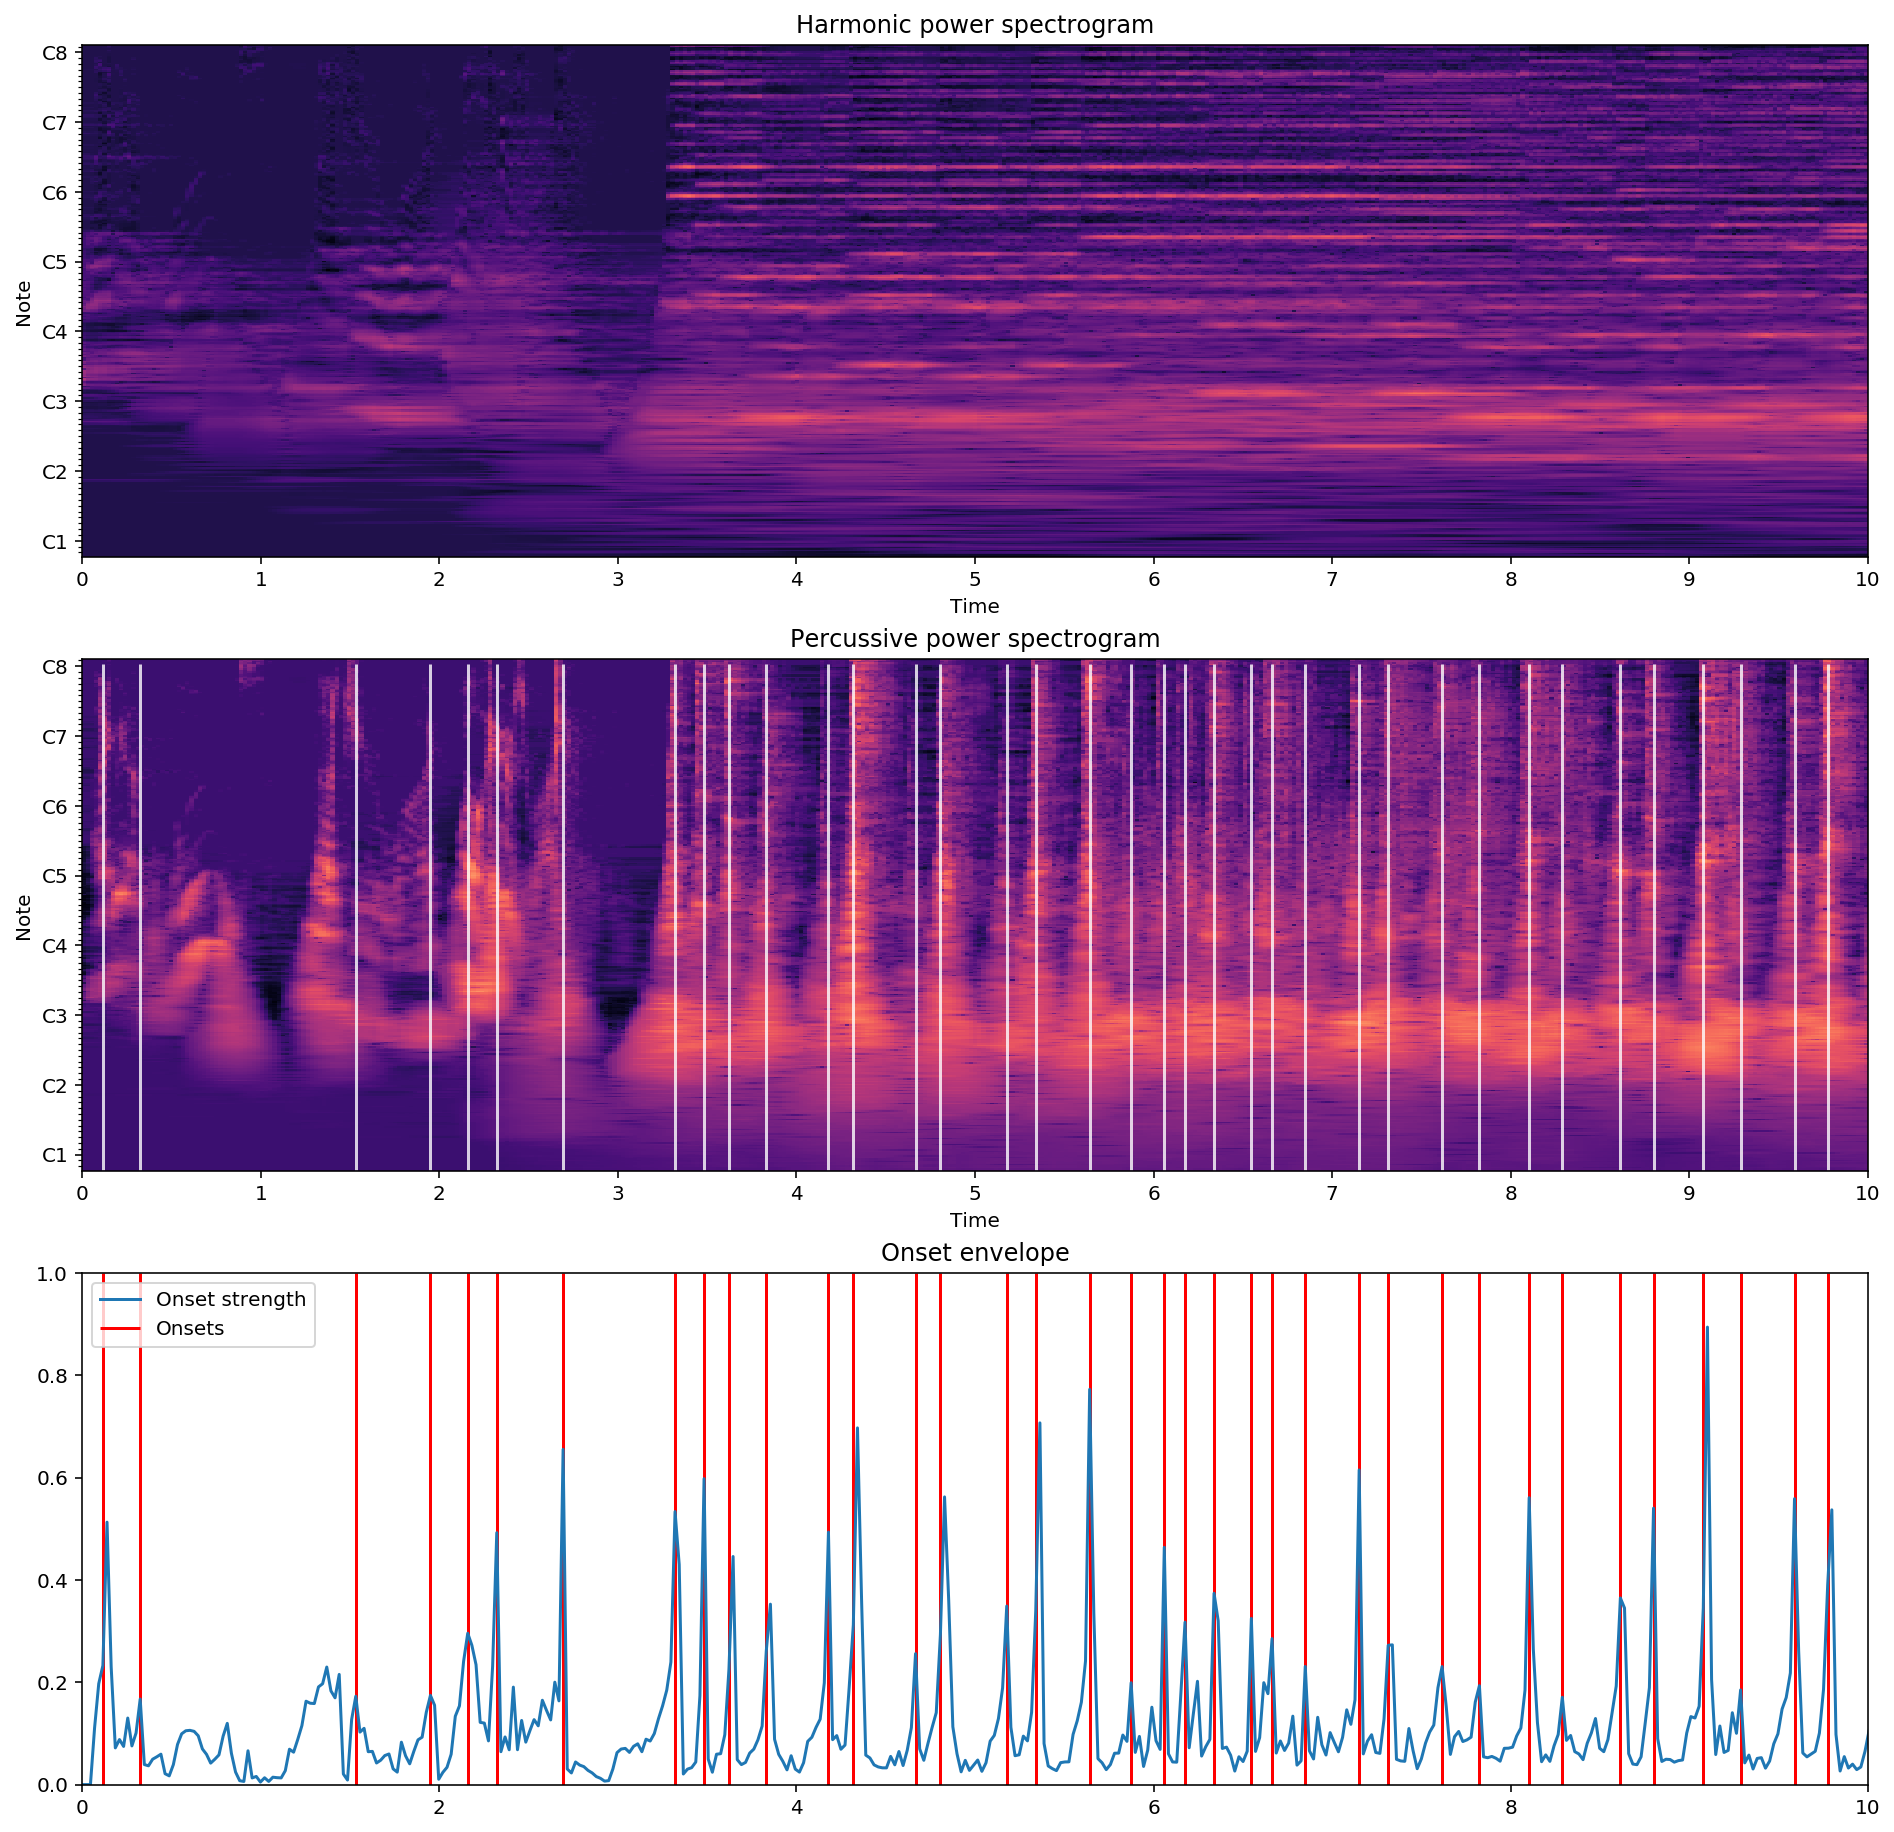

In [4]:
plt.figure(figsize=(16, 16))
ax1 = plt.subplot(3, 1, 1)
plt.title('Harmonic power spectrogram')
specshow(cqtsHarm, x_axis='time', y_axis='cqt_note', fmin=lbr.note_to_hz('A0'), bins_per_octave=12*nBins)

ax2 = plt.subplot(3, 1, 2)
plt.title('Percussive power spectrogram')
specshow(cqtsPerc, x_axis='time', y_axis='cqt_note', fmin=lbr.note_to_hz('A0'), bins_per_octave=12*nBins)

o_env = lbr.onset.onset_strength(S=cqtsPerc)
frames, times = lbr.onset.onset_detect(onset_envelope=o_env), lbr.frames_to_time(range(len(o_env)))
plt.vlines(times[frames], lbr.note_to_hz('A0'), lbr.note_to_hz('C8'), color='w', alpha=.8)

ax3 = plt.subplot(3, 1, 3)
plt.title('Onset envelope')
plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[frames], 0, o_env.max(), color='r', label='Onsets')
plt.legend()
plt.ylim(0, o_env.max())

for a in [ax1, ax2, ax3]: a.set_xlim(0, 10)

# 4. Key Signature Estimation, Option 1.
### From Kumhansl and Schmuckler as reported here:
http://rnhart.net/articles/key-finding/

In [5]:
chroma = lbr.feature.chroma_cqt(C=cqtsHarm, fmin=lbr.note_to_hz('A0'), bins_per_octave=12*nBins)[:, frames].sum(1)
major = [np.corrcoef(chroma, np.roll([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88], i))[0, 1] for i in range(12)]
minor = [np.corrcoef(chroma, np.roll([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17], i))[0, 1] for i in range(12)]

keySignature = (['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'][
    major.index(max(major)) if max(major) > max(minor) else minor.index(max(minor)) - 3]
                + ('m' if max(major) < max(minor) else ''))
keySignature

'E'

# 5. Pre-Processing of Spectrogram Data.

In [6]:
cqts = np.vstack([np.zeros((nFrames // 2, cqtsHarm.shape[0]), cqtsHarm.dtype), cqtsHarm.T,
                  np.zeros((nFrames // 2, cqtsHarm.shape[0]), cqtsHarm.dtype)])
cqts = np.array([cqts[range(f, f + nFrames)] for f in range(len(cqts) - nFrames + 1)])
'Cqts grouped.'

'Cqts grouped.'

# 6. Load CNN-Model and Predict Probabilities.

In [7]:
model = load_model('Model Dixon61 Frame54.hdf5', compile=False) # HDF5 file
yProb = model.predict(cqts, verbose=1)
SVG(model_to_dot(model, True, False, 'LR').create(format='svg'))

6710/6710 [==============================] - 14s 2ms/step


# 7. Keep Only Notes with Probabilities >= some threshold.
There could be lots of noticeable false-positive notes in high octaves where they absolutely surely should not be.<br>
If it is too annoying, then I cannot think of any better solution than to use much higher threshold for higher octaves &#x2639;

In [8]:
yPred = yProb.max(0)
if len(frames) > 1:
    yPred = yProb[:(frames[0] + frames[1]) // 2].max(0)
    for i, fr in enumerate(frames[1:-1]):
        yPred = np.vstack([yPred, yProb[(frames[i] + fr) // 2 : (fr + frames[i + 2]) // 2].max(0)])
    yPred = np.vstack([yPred, yProb[(frames[-2] + frames[-1]) // 2 :].max(0)])
''' yPred[:,   :52][yPred[:,   :52] < .5] = 0
    yPred[:, 52:64][yPred[:, 52:64] < .6] = 0
    yPred[:, 64:  ][yPred[:, 64:  ] < .7] = 0'''
yPred[yPred < 0.5] = 0

notes = Counter()
for row in yPred: notes.update(Counter(np.argwhere(row).ravel() % 12))
gamma = [n for _, n in sorted([(count, ['A', 'Bb', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab'][i])
                for i, count in notes.items()], reverse=True)[:7]]
blacks = sorted(n for n in gamma if len(n) > 1)
blacks, gamma

(['C#', 'F#'], ['E', 'A', 'B', 'D', 'C#', 'F#', 'C'])

# 8. Key Signature Estimation, Option 2.

In [9]:
MajorMinor = lambda mj, mn: mj if gamma.index(mj) < gamma.index(mn) else mn + 'm'

if len(blacks) == 0: keySignature = MajorMinor('C', 'A')

elif len(blacks) == 1:
    if blacks[0] == 'F#':
        assert 'F' not in gamma
        keySignature = MajorMinor('G', 'E')
    elif blacks[0] == 'Bb':
        assert 'B' not in gamma
        keySignature = MajorMinor('F', 'D')
    else: assert False

elif len(blacks) == 2:
    if blacks == ['C#', 'F#']:
        assert 'C' not in gamma and 'F' not in gamma
        keySignature = MajorMinor('D', 'B')
    elif blacks == ['Bb', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma
        keySignature = MajorMinor('Bb', 'G')
    else: assert False

elif len(blacks) == 3:
    if blacks == ['Ab', 'C#', 'F#']:
        assert 'C' not in gamma and 'F' not in gamma and 'G' not in gamma
        keySignature = MajorMinor('A', 'F#')
    elif blacks == ['Ab', 'Bb', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma and 'A' not in gamma
        keySignature = MajorMinor('Eb', 'C')
    else: assert False

elif len(blacks) == 4:
    if blacks == ['Ab', 'C#', 'Eb', 'F#']:
        assert 'C' not in gamma and 'D' not in gamma and 'F' not in gamma and 'G' not in gamma
        keySignature = MajorMinor('E', 'C#')
    elif blacks == ['Ab', 'Bb', 'C#', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma and 'A' not in gamma and 'D' not in gamma
        keySignature = MajorMinor('Ab', 'F')
    else: assert False

elif 'B' in gamma and 'E' in gamma: keySignature = MajorMinor('B', 'Ab')
elif 'C' in gamma and 'F' in gamma: keySignature = MajorMinor('C#', 'Bb')
else: assert False

keySignature

AssertionError: 

# 9. Finally, Write MIDI.

In [10]:
microSecPerBeat, ppqn = mido.bpm2tempo(lbr.beat.tempo(song).mean()), 480
midi, track = mido.MidiFile(ticks_per_beat=ppqn), mido.MidiTrack()
midi.tracks.append(track)
track.append(mido.MetaMessage('text',          text  = 'Automatically transcribed from audio:\r\n\t' + songName))
track.append(mido.MetaMessage('copyright',     text  = 'Used software created by Boris Shakhovsky'))
track.append(mido.MetaMessage('set_tempo',     tempo = microSecPerBeat))
track.append(mido.MetaMessage('key_signature', key   = keySignature))

for i, note in enumerate(np.argwhere(yPred[0]).ravel()): track.append(mido.Message('note_on', note=note+21,
                                                                                   velocity=int(0x7F * yPred[0][note])))
times = lbr.frames_to_time(frames)
for i, t in enumerate(times[1:]):
    track.append(mido.Message('note_off', note=0, time=int(mido.second2tick(t - times[i], ppqn, microSecPerBeat))))
    for note in np.argwhere(yPred[i]).ravel():           track.append(mido.Message('note_off', note=note+21))
    for note in np.argwhere(yPred[i + 1]).ravel():       track.append(mido.Message('note_on',  note=note+21,
                                                                                   velocity=int(0x7F * yPred[i + 1][note])))
midiOutFile = '.'.join(songName.split('.')[:-1]) + '.mid'
midi.save(midiOutFile)
print('"{}" saved'.format(midiOutFile))

"./Test songs/Big Bill Broonzy & Chas Segar - Key to the Highway (Cover by Rog Bates).mid" saved
